### Introduction
In this exercise you will build three (optionally four) different networks to experiment with one of the applications of recurrent neural networks called Machine Translation. The preprocessing pipeline that prepares the input data for feeding into the neural network models is provided to you. Therefore, in this excercise you focus on building and experimenting with different network architectures. 

Optional: To learn more about recurrent neural networks (such as RNN, GRU, and LSTM) their architectures, the differences between them and their applications you can watch this free tutorial: [Sequences and Recurrent networks Tutorial](https://www.youtube.com/watch?v=87kLfzmYBy8&ab_channel=DeepMind)

[Find a good descripton here](https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571)

In [2]:
# You may want to upgrade the tensorflow package to the latest verion (currently version 2.3) if you have the proper infrastructure
# !pip install --upgrade tensorflow

### Setup


In [3]:
# To get access to a GPU instance you can use the `change runtime type` and set the option to `GPU` from the `Runtime` tab  in the notebook
# Checking the GPU availability for the notebook
import tensorflow
tensorflow.test.gpu_device_name()

''

In [4]:
# import collection
import io
import pandas as pd
import numpy as np
from typing import List 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

### Loading and Preprocessing the Data

#### Reading CSV data files as a list of strings, where each string represents a single line from the text


In [5]:
import csv
from io import TextIOWrapper
from zipfile import ZipFile

In [6]:
import requests


url = 'https://github.com/murpi/wilddata/blob/master/quests/small_vocab_en.csv.zip?raw=true'
r = requests.get(url, allow_redirects=True)

open('small_vocab_en.csv.zip', 'wb').write(r.content)

url = 'https://github.com/murpi/wilddata/blob/master/quests/small_vocab_fr.csv.zip?raw=true'
r = requests.get(url, allow_redirects=True)

open('small_vocab_fr.csv.zip', 'wb').write(r.content)

1367852

In [7]:
with ZipFile('small_vocab_en.csv.zip') as zf:
    with zf.open('small_vocab_en.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'), delimiter='\n' )
        english_text = [item for sublist in reader for item in sublist]
        print(f"English text samples: {english_text[0:2]}")

English text samples: ['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .']


In [8]:
with ZipFile('small_vocab_fr.csv.zip') as zf:
    with zf.open('small_vocab_fr.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'), delimiter='\n' )
        french_text = [item for sublist in reader for item in sublist]
        print(f"French translation text samples: {french_text[0:2]}")


French translation text samples: ["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .']


In [9]:
# TODO: Data exploration -> calculate and print some statistics on data

w_en_count = 0
w_en_set = set()
for i in english_text:
    i = i.replace(',', ' ')
    w_en_count += len(i.split())
    w_en_set.update(i.strip('.?').split())

w_fr_count = 0
w_fr_set = set()
for i in french_text:
    i = i.replace(',', ' ')
    w_fr_count += len(i.split())
    w_fr_set.update(i.strip('.?').split())


In [10]:
print (f"number of english_text items: {len(english_text)}")
print (f"number of french_text items: {len(french_text)}")
print (f"number of words in the english_text: {w_en_count}")
print (f"number of words in the french_text: {w_fr_count}")
print (f"number of unique words in the english_text: {len(w_en_set)}")
print (f"number of unique words in the french_text: {len(w_fr_set)}")

number of english_text items: 137860
number of french_text items: 137860
number of words in the english_text: 1682353
number of words in the french_text: 1838160
number of unique words in the english_text: 199
number of unique words in the french_text: 350


#### Tokenizing the data

Since the input data to neural networks needs to be in numerical format, we first turn each sentence into a sequence of word ids using `Tokenizer` function from Keras. Word ids are numerical presentations for words. 

In [11]:
def tokenize(x: List[str]):
  """Tokenizes sentences into word ids.
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)

  """
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(x)
  t=tokenizer.texts_to_sequences(x)
  return t, tokenizer

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent)) 

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}
Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


#### Padding Sequences

To be able to batch the sequences of word ids together, all sequences need to be of the same length. Therefore, as a second preprocessing step we make sure that all the English sentences have the same length as their respective French translations using `pad_sequence` function form Keras.

In [12]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


#### Preprocessing Pipeline

As mentioned in the introduction section in this excercise your focus is on building different recurrent neural network architectures. Threfore, in the following cell we provide you with a preprocessing pipeline. You can apply this function to the input data to prepare the data for using in neural networks.

In [13]:
def preprocess(x, y):
    """
     Preprocess input (x) and target (y)
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_text, french_text)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Preprocessed Data Info')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Preprocessed Data Info
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


### Models

In this section we ask you to build and train Three (optionally four) different neural networks and use them to predict the French Translation of the English sentences.

Make use of the `logits_to_text()` function to transform the logits from output of your networks to a French translation. This helps you to better understand the output of the neural network.

In [14]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


#### Model 1: Implement a simple RNN network and train the network. 


In [15]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Input,InputLayer, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
# this step is necessary in order to set the length of the input sequences not shorter than the output length
print("Before: ",preproc_english_sentences.shape)
preproc_english_sentences = pad(preproc_english_sentences, length=max_french_sequence_length)
print("After: ",preproc_english_sentences.shape)

Before:  (137860, 15)
After:  (137860, 21)


In [ ]:
# Model 1: simple RNN model
EarlyStoping = EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=3)


def rnn_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers and compile the model. (Hint: Use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module)
    # What is the input shape of your model? Which activation function do you choose for the dense layer?
    
    model = Sequential() # Complete here
    
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))

    return model


# model = rnn_model(preproc_english_sentences_21.shape,max_french_sequence_length,english_vocab_size+1,french_vocab_size+1)
model_rnn = rnn_model((preproc_english_sentences.shape[1], 1), max_french_sequence_length,english_vocab_size+1,french_vocab_size+1)

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 64)            12864     
_________________________________________________________________
time_distributed (TimeDistri (None, 21, 345)           22425     
Total params: 35,289
Trainable params: 35,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preproc_english_sentences[5]

array([31, 11, 13,  1,  5, 84,  6, 30, 11,  1,  5, 82,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)

In [ ]:
model_rnn.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(0.005),
              metrics=['accuracy'])

# TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)
X, y = preproc_english_sentences, preproc_french_sentences
X  = X.reshape(-1, X.shape[1], 1)
print(X.shape, y.shape)

# TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?
history = model_rnn.fit(X, y, epochs=10, batch_size=1000, validation_split=0.2, callbacks=[EarlyStoping])

(137860, 21, 1) (137860, 21, 1)
Epoch 1/10
111/111 [==============================] - 71s 618ms/step - loss: 3.2674 - accuracy: 0.4284 - val_loss: 1.9049 - val_accuracy: 0.5616
Epoch 2/10
111/111 [==============================] - 68s 613ms/step - loss: 1.7783 - accuracy: 0.5743 - val_loss: 1.5402 - val_accuracy: 0.5967
Epoch 3/10
111/111 [==============================] - 66s 599ms/step - loss: 1.4959 - accuracy: 0.6032 - val_loss: 1.3896 - val_accuracy: 0.6180
Epoch 4/10
111/111 [==============================] - 66s 598ms/step - loss: 1.3642 - accuracy: 0.6249 - val_loss: 1.2994 - val_accuracy: 0.6404
Epoch 5/10
111/111 [==============================] - 65s 584ms/step - loss: 1.2822 - accuracy: 0.6392 - val_loss: 1.2279 - val_accuracy: 0.6431
Epoch 6/10
111/111 [==============================] - 65s 589ms/step - loss: 1.2174 - accuracy: 0.6491 - val_loss: 1.1934 - val_accuracy: 0.6568
Epoch 7/10
111/111 [==============================] - 66s 593ms/step - loss: 1.1732 - accuracy: 0.

In [ ]:
# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text. 

s_list = [63, 69, 79, 245]      # list of sentences randomly chosen by me
index_to_e_words = {id: word for word, id in english_tokenizer.word_index.items()}   # dict of english words
index_to_e_words[0] = '<PAD>'                                                        # add PAD to the list
index_to_fr_words = {id: word for word, id in french_tokenizer.word_index.items()}   # dict of french words
index_to_fr_words[0] = '<PAD>'                                                       # add PAD to the list


for s in s_list:
    print(f"English: {' '.join([index_to_e_words[word] for word in X[s].reshape(21)])}")
    print(f"Fr_true: {' '.join([index_to_fr_words[word] for word in y[s].reshape(21)])}")
    print(f"Fr_pred: {(logits_to_text(model_rnn.predict(X[s:(s+1)])[0], french_tokenizer))}\n")

English: the lemon is my most loved fruit but the strawberry is our most loved <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: le citron est mon fruit le plus aimé mais la fraise est notre plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_pred: les chaux est son fruit le plus aimé mais la est est notre plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

English: he dislikes apples mangoes and strawberries <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: il déteste les pommes les mangues et les fraises <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_pred: elle aime les les les et et les <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

English: the strawberry is their least favorite fruit but the apple is our least favorite <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: la fraise est leur fruit préféré moins mais la pomme est notre moins préféré <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

#### Model 2: Implement an RNN model using word embeddings

Embeddings are better representation of words. An embedding is a vector representation of a word in n-dimensional space, where n represents the size of the embedding vector.


In [ ]:
# Model 2: Embedding
EarlyStoping = EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=3)

def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers and compile the model. (Hint: Similar to the first model use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module. 
    # And this time make use of Embedding as well!)
    # What is the input shape of your model? Which activation function do you choose for the dense layer?
    embedding_size = 128  # a common choice but fully arbitrary chosen here 
    model = Sequential() 
    # Complete here
    model.add(Embedding(english_vocab_size, 64, input_shape=input_shape))
    model.add(GRU(64, return_sequences=True))                   
    model.add(TimeDistributed(Dense(french_vocab_size, activation="softmax")))
                       
    return model

model_embeding = embed_model((preproc_english_sentences.shape[1], ),max_french_sequence_length,english_vocab_size+1,french_vocab_size+1) 
model_embeding.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 64)            12800     
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 64)            24960     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 345)           22425     
Total params: 60,185
Trainable params: 60,185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_embeding.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(0.005),
              metrics=['accuracy'])
              
# TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)
X, y = preproc_english_sentences, preproc_french_sentences
X  = X.reshape(-1, X.shape[1], 1)
print(X.shape, y.shape)

# TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?
histemb=model_embeding.fit(X, y, validation_split=0.2, epochs=10, batch_size=1000, verbose=1,callbacks=[EarlyStoping])


(137860, 21, 1) (137860, 21, 1)
Epoch 1/10
111/111 [==============================] - 72s 630ms/step - loss: 3.5734 - accuracy: 0.4150 - val_loss: 1.4906 - val_accuracy: 0.6160
Epoch 2/10
111/111 [==============================] - 69s 626ms/step - loss: 1.2476 - accuracy: 0.6773 - val_loss: 0.7516 - val_accuracy: 0.7842
Epoch 3/10
111/111 [==============================] - 69s 624ms/step - loss: 0.6814 - accuracy: 0.8034 - val_loss: 0.5369 - val_accuracy: 0.8393
Epoch 4/10
111/111 [==============================] - 70s 631ms/step - loss: 0.5104 - accuracy: 0.8457 - val_loss: 0.4443 - val_accuracy: 0.8658
Epoch 5/10
111/111 [==============================] - 72s 655ms/step - loss: 0.4241 - accuracy: 0.8720 - val_loss: 0.3832 - val_accuracy: 0.8835
Epoch 6/10
111/111 [==============================] - 75s 678ms/step - loss: 0.3706 - accuracy: 0.8879 - val_loss: 0.3460 - val_accuracy: 0.8954
Epoch 7/10
111/111 [==============================] - 73s 659ms/step - loss: 0.3353 - accuracy: 0.

In [ ]:
# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text. 
# (Hint: If you predict on the same sentence you can compare the result of different model on that specific sentence with each other.)

for s in s_list:
    print(f"English: {' '.join([index_to_e_words[word] for word in X[s].reshape(21)])}")
    print(f"Fr_true: {' '.join([index_to_fr_words[word] for word in y[s].reshape(21)])}")
    print(f"Fr_pred: {(logits_to_text(model_embeding.predict(X[s:(s+1)])[0], french_tokenizer))}\n")

English: the lemon is my most loved fruit but the strawberry is our most loved <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: le citron est mon fruit le plus aimé mais la fraise est notre plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_pred: les citron est mon fruit le plus cher mais la fraise est notre plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

English: he dislikes apples mangoes and strawberries <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: il déteste les pommes les mangues et les fraises <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_pred: il n'aime les pommes les mangues et les fraises <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

English: the strawberry is their least favorite fruit but the apple is our least favorite <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: la fraise est leur fruit préféré moins mais la pomme est notre moins préféré <PAD> <PAD> <PAD> <PAD

#### Model 3: Implement a Bidirectional RNN network.

One of the restrictions of RNN networks is that they only see the data from past. However, Bidirectional RNNs can see the data in both directions past and future. Make use of Bidirectionality and experiment if this feature enhances your network's performance or not.

In [ ]:
# Model 3: Bidirectional RNNs
EarlyStoping = EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=3)

def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO:  Build the layers and compile the model. (Hint: Similar to the first model use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module. 
    # Don't forget to make your network bidirectional!)

    model = Sequential()
    # Complete here
    model.add(Embedding(english_vocab_size, 64, input_shape=input_shape))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    #model.add(TimeDistributed(Dense(256, activation="relu")))      
    model.add(TimeDistributed(Dense(french_vocab_size, activation="softmax"))                  )

    return model

model_bd = bd_model((preproc_english_sentences.shape[1], ),max_french_sequence_length,english_vocab_size+1,french_vocab_size+1) 
model_bd.summary()
#histbd=model_bidirectional.fit(preproc_english_sentences,preproc_french_sentences,validation_split=0.2, epochs=100, verbose=1,callbacks=[EarlyStoping])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 64)            12800     
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 128)           49920     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 345)           44505     
Total params: 107,225
Trainable params: 107,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_bd.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(0.005),
              metrics=['accuracy'])
              
# TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)
X, y = preproc_english_sentences, preproc_french_sentences
X  = X.reshape(-1, X.shape[1], 1)
print(X.shape, y.shape)

# TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?
histbd=model_bd.fit(X, y, validation_split=0.2, epochs=10, batch_size=1000, verbose=1,callbacks=[EarlyStoping])

(137860, 21, 1) (137860, 21, 1)
Epoch 1/10
111/111 [==============================] - 105s 912ms/step - loss: 3.1403 - accuracy: 0.4614 - val_loss: 1.0622 - val_accuracy: 0.7133
Epoch 2/10
111/111 [==============================] - 100s 899ms/step - loss: 0.8880 - accuracy: 0.7464 - val_loss: 0.5379 - val_accuracy: 0.8396
Epoch 3/10
111/111 [==============================] - 103s 930ms/step - loss: 0.4883 - accuracy: 0.8525 - val_loss: 0.3731 - val_accuracy: 0.8870
Epoch 4/10
111/111 [==============================] - 99s 893ms/step - loss: 0.3452 - accuracy: 0.8963 - val_loss: 0.2928 - val_accuracy: 0.9138
Epoch 5/10
111/111 [==============================] - 100s 899ms/step - loss: 0.2762 - accuracy: 0.9186 - val_loss: 0.2427 - val_accuracy: 0.9291
Epoch 6/10
111/111 [==============================] - 100s 901ms/step - loss: 0.2269 - accuracy: 0.9346 - val_loss: 0.2069 - val_accuracy: 0.9403
Epoch 7/10
111/111 [==============================] - 98s 880ms/step - loss: 0.1968 - accurac

In [ ]:
# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text.
# (Hint: If you predict on the same sentence you can compare the result of different model on that specific sentence with each other.)
for s in s_list:
    print(f"English: {' '.join([index_to_e_words[word] for word in X[s].reshape(21)])}")
    print(f"Fr_true: {' '.join([index_to_fr_words[word] for word in y[s].reshape(21)])}")
    print(f"Fr_pred: {(logits_to_text(model_bd.predict(X[s:(s+1)])[0], french_tokenizer))}\n")

English: the lemon is my most loved fruit but the strawberry is our most loved <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: le citron est mon fruit le plus aimé mais la fraise est notre plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_pred: le citron est mon fruit le plus aimé mais la fraise est notre plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

English: he dislikes apples mangoes and strawberries <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: il déteste les pommes les mangues et les fraises <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_pred: il déteste les les les mangues et les fraises <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

English: the strawberry is their least favorite fruit but the apple is our least favorite <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: la fraise est leur fruit préféré moins mais la pomme est notre moins préféré <PAD> <PAD> <PAD> <PAD> <

In [ ]:
tensorflow.keras.backend.clear_session()   # Resets all state generated by Keras

First I tried to apply the bidirectional layer on the basic RNN model. The results were almost identical as with the basic model. After that I combined the bidirectional layer with word embedding (what is actually the  optional task, see below). With that model the improvement (measured by accuracy) is significant

#### Model 4: Implement an Encoder-Decoder model (Optional)

In [ ]:

def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    model = Sequential()
    model.add(Embedding(english_vocab_size, 64, input_shape=input_shape))
    # Encoder
    model.add(Bidirectional(GRU(64, return_sequences = False)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(TimeDistributed(Dense(french_vocab_size, activation="softmax"))                  )

    return model

model_encdec = encdec_model((preproc_english_sentences.shape[1], ),max_french_sequence_length,english_vocab_size+1,french_vocab_size+1) 
model_encdec.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 64)            12800     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49920     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 21, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 128)           74496     
_________________________________________________________________
time_distributed (TimeDistri (None, 21, 345)           44505     
Total params: 181,721
Trainable params: 181,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# OPTIONAL: Train and Print prediction(s)

model_encdec.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(0.005),
              metrics=['accuracy'])
              
# TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)
X, y = preproc_english_sentences, preproc_french_sentences
X  = X.reshape(-1, X.shape[1], 1)
print(X.shape, y.shape)

# TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?
histencdec = model_encdec.fit(X, y, validation_split=0.2, epochs=10, batch_size=1000, verbose=1,callbacks=[EarlyStoping])


(137860, 21, 1) (137860, 21, 1)
Epoch 1/10
111/111 [==============================] - 154s 1s/step - loss: 3.2528 - accuracy: 0.4169 - val_loss: 1.9401 - val_accuracy: 0.5169
Epoch 2/10
111/111 [==============================] - 150s 1s/step - loss: 1.8161 - accuracy: 0.5375 - val_loss: 1.4817 - val_accuracy: 0.6120
Epoch 3/10
111/111 [==============================] - 158s 1s/step - loss: 1.4174 - accuracy: 0.6256 - val_loss: 1.2010 - val_accuracy: 0.6682
Epoch 4/10
111/111 [==============================] - 150s 1s/step - loss: 1.1479 - accuracy: 0.6820 - val_loss: 0.9997 - val_accuracy: 0.7167
Epoch 5/10
111/111 [==============================] - 141s 1s/step - loss: 0.9642 - accuracy: 0.7237 - val_loss: 0.8614 - val_accuracy: 0.7472
Epoch 6/10
111/111 [==============================] - 141s 1s/step - loss: 0.8284 - accuracy: 0.7573 - val_loss: 0.7532 - val_accuracy: 0.7800
Epoch 7/10
111/111 [==============================] - 148s 1s/step - loss: 0.7372 - accuracy: 0.7836 - val_los

In [ ]:
# Print predictions
for s in s_list:
    print(f"English: {' '.join([index_to_e_words[word] for word in X[s].reshape(21)])}")
    print(f"Fr_true: {' '.join([index_to_fr_words[word] for word in y[s].reshape(21)])}")
    print(f"Fr_pred: {(logits_to_text(model_encdec.predict(X[s:(s+1)])[0], french_tokenizer))}\n")

English: the lemon is my most loved fruit but the strawberry is our most loved <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: le citron est mon fruit le plus aimé mais la fraise est notre plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_pred: le citron est son fruit le plus cher mais la mangue est votre plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

English: he dislikes apples mangoes and strawberries <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: il déteste les pommes les mangues et les fraises <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_pred: il déteste les les les raisins et les fraises <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

English: the strawberry is their least favorite fruit but the apple is our least favorite <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Fr_true: la fraise est leur fruit préféré moins mais la pomme est notre moins préféré <PAD> <PAD> <PAD> <PAD> <

#### Finally, you can use all the models you built in this exercise to create a model that incorporates embedding and bidirectionality into one model. (Optional)

It has been already done by implementing model 3 (and 4)

In [ ]:

def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    return model
# OPTIONAL: Train and Print prediction(s)

### Final Notes and TODOs




*   In this exercise we focus on  learning different recurrent network architectures for machine translation, However we don't evaluate the models on a separate test set. To follow best machine learning practices, you can make use of the `sklearn.model_selecttion.train_test_split()` function to create separate training and test datasets. You can then retrain each of the models on the training set and evaluate the prediction accuracy using the hold out set. Observe how the best model performance might change.
* If you don't have any idea about French (like me :D) you can use a translater like [google translat](https://translate.google.com/) to compare the prediction(s) from your models with the respective original English sentence(s).
*   TODO: Finally, you can also try to train and predict your models on other language pairs. As a convenient example, you can use your models to translate from French to English since you already have the data available.





## Reverse translation (French to English)

In [ ]:
# apply the "best" model to a reverse translation, i.e. translate from French to English.

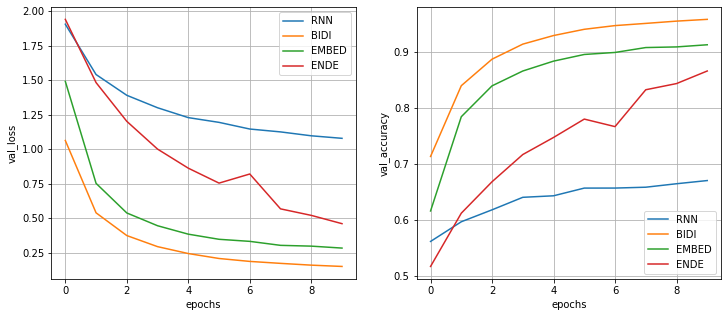

In [ ]:
import matplotlib.pyplot as plt

# histbd.history.
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history.get('val_loss'), label='RNN')
plt.plot(histbd.history.get('val_loss'), label='BIDI')
plt.plot(histemb.history.get('val_loss'), label='EMBED')
plt.plot(histencdec.history.get('val_loss'), label='ENDE')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(history.history.get('val_accuracy'), label='RNN')
plt.plot(histbd.history.get('val_accuracy'), label='BIDI')
plt.plot(histemb.history.get('val_accuracy'), label='EMBED')
plt.plot(histencdec.history.get('val_accuracy'), label='ENDE')
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# execute a new preprocessing with exchanged input/output languages

preproc_french_sentences, preproc_english_sentences, french_tokenizer, english_tokenizer =\
    preprocess(french_text, english_text)
    
max_french_sequence_length = preproc_french_sentences.shape[1]
max_english_sequence_length = preproc_english_sentences.shape[1]
french_vocab_size = len(french_tokenizer.word_index)
english_vocab_size = len(english_tokenizer.word_index)

print('Preprocessed Data Info')
print("Max French sentence length:", max_french_sequence_length)
print("Max English sentence length:", max_english_sequence_length)
print("French vocabulary size:", french_vocab_size)
print("English vocabulary size:", english_vocab_size)


Preprocessed Data Info
Max French sentence length: 21
Max English sentence length: 15
French vocabulary size: 344
English vocabulary size: 199


In [35]:
#the "best" model is BIDI. Compile and fit the model with exchanged x and y

EarlyStoping = EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=3)


def bd_model_rev(input_shape, output_sequence_length, french_vocab_size, english_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO:  Build the layers and compile the model. (Hint: Similar to the first model use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module. 
    # Don't forget to make your network bidirectional!)

    model = Sequential()
    # Complete here
    model.add(Embedding(french_vocab_size, 64, input_shape=input_shape))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    #model.add(TimeDistributed(Dense(256, activation="relu")))      
    model.add(TimeDistributed(Dense(english_vocab_size, activation="softmax"))                  )

    return model

model_bd_rev = bd_model_rev((preproc_french_sentences.shape[1], ),max_french_sequence_length, french_vocab_size+1, english_vocab_size+1 ) 
model_bd_rev.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 21, 64)            22080     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 21, 128)           49920     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 21, 200)           25800     
Total params: 97,800
Trainable params: 97,800
Non-trainable params: 0
_________________________________________________________________


In [28]:
preproc_english_sentences.shape

(137860, 21)

In [29]:
# pad it equal to the french_sentences max. length
preproc_english_sentences = pad(preproc_english_sentences, length=max_french_sequence_length)

In [39]:
# do it this time with separated train/test data sets!

from sklearn.model_selection import train_test_split


model_bd_rev.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(0.005),
              metrics=['accuracy'])
              

x, y =  preproc_french_sentences, preproc_english_sentences  # this time in reverse order!
x  = x.reshape(-1, x.shape[1], 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)

histbd_reverse = model_bd_rev.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=1000, verbose=1, callbacks=[EarlyStoping])

(110288, 21, 1) (110288, 21)
Epoch 1/10
89/89 [==============================] - 68s 722ms/step - loss: 2.1764 - accuracy: 0.5360 - val_loss: 0.7376 - val_accuracy: 0.8072
Epoch 2/10
89/89 [==============================] - 63s 710ms/step - loss: 0.5314 - accuracy: 0.8588 - val_loss: 0.2268 - val_accuracy: 0.9372
Epoch 3/10
89/89 [==============================] - 63s 714ms/step - loss: 0.1904 - accuracy: 0.9464 - val_loss: 0.1190 - val_accuracy: 0.9630
Epoch 4/10
89/89 [==============================] - 64s 718ms/step - loss: 0.1043 - accuracy: 0.9676 - val_loss: 0.0783 - val_accuracy: 0.9736
Epoch 5/10
89/89 [==============================] - 63s 708ms/step - loss: 0.0714 - accuracy: 0.9755 - val_loss: 0.0616 - val_accuracy: 0.9776
Epoch 6/10
89/89 [==============================] - 64s 725ms/step - loss: 0.0570 - accuracy: 0.9791 - val_loss: 0.0513 - val_accuracy: 0.9805
Epoch 7/10
89/89 [==============================] - 64s 719ms/step - loss: 0.0479 - accuracy: 0.9815 - val_loss: 

In [41]:
x_test.shape

(27572, 21, 1)

In [54]:
# TODO: Print prediction(s) for one or more of the French sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text. 

import random

s_list = [random.randint(1, x_test.shape[0]) for i in range(3)]                   # list of random sentences
index_to_e_words = {id: word for word, id in english_tokenizer.word_index.items()}    # dict of french words
index_to_e_words[0] = '<PAD>'                                                        # add PAD to the list
index_to_fr_words = {id: word for word, id in french_tokenizer.word_index.items()}  # dict of english words
index_to_fr_words[0] = '<PAD>'                                                       # add PAD to the list


for s in s_list:
    print(s)
    print(f"French: {' '.join([index_to_fr_words[word] for word in x_test[s].reshape(21)])}")
    print(f"En_true: {' '.join([index_to_e_words[word] for word in y_test[s].reshape(21)])}")
    print(f"En_pred: {(logits_to_text(model_bd_rev.predict(x_test[s:(s+1)])[0], english_tokenizer))}\n")

7665
French: france est calme pendant l' été et il est parfois humide en hiver <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
En_true: france is quiet during summer and it is sometimes wet in winter <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
En_pred: france is quiet during summer and it is sometimes wet in winter <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

26811
French: les états unis est généralement froid au mois de mai mais il est généralement humide en été <PAD> <PAD> <PAD> <PAD>
En_true: the united states is usually chilly during may but it is usually wet in summer <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
En_pred: the united states is usually cold during may but it is usually wet in summer <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

19298
French: notre fruit préféré est l'orange mais leur favori est le raisin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
En_true: our favorite fruit is the orange but their favorite is the grape <PAD> <PAD> <PAD> <PAD> <PAD>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a109ea11-a7da-42aa-8af0-3a0cdafc917e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>